# ViViT : Video Vision Transformer

<img src='https://github.com/rishikksh20/ViViT-pytorch/blob/master/assets/model.PNG?raw=true' width='800'> 

벤치마크 데이터셋인 UCF101 데이터셋의 서브샘플링된 버전

In [1]:
#!wget -q https://git.io/JGc31 -O ucf101_top5.tar.gz
#!tar xf ucf101_top5.tar.gz

## Setup

In [2]:
import torch
from torch import Tensor, einsum
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchinfo import summary

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import imageio
import cv2
import os
from einops import rearrange, repeat
from tqdm.notebook import tqdm
import math
import sys
import warnings
from collections import Counter

warnings.filterwarnings('ignore')

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

In [4]:
torchvision.__version__

'0.9.0+cu111'

## Define hyperparameters

In [5]:
MAX_SEQ_LENGTH = 20
NUM_FEATURES = 1000
IMG_SIZE = 224

## Data preparation

In [6]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

print(f"Total videos for training: {len(train_df)}")
print(f"Total videos for testing: {len(test_df)}")

Total videos for training: 594
Total videos for testing: 224


In [7]:
train_df

,video_name,tag
0,v_CricketShot_g08_c01.avi,CricketShot
1,v_CricketShot_g08_c02.avi,CricketShot
2,v_CricketShot_g08_c03.avi,CricketShot
3,v_CricketShot_g08_c04.avi,CricketShot
4,v_CricketShot_g08_c05.avi,CricketShot
...,...,...
589,v_TennisSwing_g25_c02.avi,TennisSwing
590,v_TennisSwing_g25_c03.avi,TennisSwing
591,v_TennisSwing_g25_c04.avi,TennisSwing
592,v_TennisSwing_g25_c05.avi,TennisSwing


In [8]:
import time 
import ipywidgets as widgets 
import IPython.display as display 
import copy 

cap = cv2.VideoCapture('./train/v_CricketShot_g08_c02.avi') 
wImg = widgets.Image( layout = widgets.Layout(border="solid") ) 
display.display(wImg) 

if cap.isOpened(): 
    ret, img = cap.read() 
    while ret: 
        tmpStream = cv2.imencode(".jpeg", img)[1].tostring() 
        wImg.value = tmpStream 
        time.sleep(0.05) 
        ret, img = cap.read() 
cap.release()


Image(value=b'', layout="Layout(border='solid')")

In [9]:
preprocess = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

def crop_center(frame):
    cropped = preprocess(frame)
    cropped = cropped.numpy().squeeze()
    return cropped

def load_video(path, max_frames=0):
    cap = cv2.VideoCapture(path)
    frames = []
    try:
        while True:
            # 정상적으로 읽어왔는지 -> retval
            # 읽어온 프레임 -> frame
            ret, frame = cap.read()
            if not ret:
                break
                
            frame = crop_center(frame)
            frames.append(frame)
            
            if len(frames) == max_frames:
                break
    finally:
        cap.release()
    return np.array(frames)

In [10]:
classes = train_df['tag'].unique()

In [11]:
classes

array(['CricketShot', 'PlayingCello', 'Punch', 'ShavingBeard',
       'TennisSwing'], dtype=object)

In [12]:
def prepare_all_videos(df, root_dir):
    num_samples = len(df)
    video_paths = df["video_name"].values.tolist()
    classes = train_df['tag'].unique()
    labels = df["tag"].values
    labels = np.array(list(map(lambda x: np.where(classes==x), labels)))
    labels = labels.squeeze(1)
    
    frame_features = np.zeros(
        shape=(num_samples, MAX_SEQ_LENGTH, 3, IMG_SIZE, IMG_SIZE), dtype="float32"
    )

    # For each video.
    for idx, path in enumerate(tqdm(video_paths)):
        # Gather all its frames and add a batch dimension.
        frames = load_video(os.path.join(root_dir, path))
        
        # Pad shorter videos.
        if len(frames) < MAX_SEQ_LENGTH:
            diff = MAX_SEQ_LENGTH - len(frames)
            padding = np.zeros((diff, 3, IMG_SIZE, IMG_SIZE))
            frames = np.concatenate(frames, padding)
            
        frames = frames[:20]
        frames = frames[None, ...]
        
        frame_features[idx] = frames

    return frame_features, labels

In [13]:
train_data, train_labels = prepare_all_videos(train_df, './train')
test_data, test_labels = prepare_all_videos(test_df, './test')

In [14]:
class CustomDataset(Dataset): 
    def __init__(self, x_tensor, y_tensor):
        self.x = x_tensor
        self.y = y_tensor

    def __len__(self): 
        return len(self.y)

    def __getitem__(self, index): 
        return self.x[index], self.y[index]

In [15]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_data, train_labels, 
                                                    test_size=0.15, 
                                                    shuffle=True,
                                                    stratify=train_labels, 
                                                    random_state=72)

In [16]:
from collections import Counter
Counter(y_train.squeeze())

Counter({4: 99, 3: 100, 1: 102, 0: 100, 2: 103})

In [18]:
params = {'batch_size': 32,
          'shuffle': True,
          'num_workers': 8,
          'pin_memory' : True}

x_train = torch.FloatTensor(x_train)
y_train = torch.LongTensor(y_train)
x_val = torch.FloatTensor(x_val)
y_val = torch.LongTensor(y_val)
x_test = torch.FloatTensor(test_data)
y_test = torch.LongTensor(test_labels)

tr_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
trainloader = DataLoader(dataset=tr_dataset, **params)
validloader = DataLoader(dataset=val_dataset, **params)

## Building the Transformer-based model

In [19]:
class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)

class FeedForward(nn.Module):
    def __init__(self, dim, hidden_dim, dropout = 0.):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, dim),
            nn.Dropout(dropout)
        )
    def forward(self, x):
        return self.net(x)

class Attention(nn.Module):
    def __init__(self, dim, heads = 8, dim_head = 64, dropout = 0.):
        super().__init__()
        inner_dim = dim_head *  heads
        project_out = not (heads == 1 and dim_head == dim)

        self.heads = heads
        self.scale = dim_head ** -0.5

        self.to_qkv = nn.Linear(dim, inner_dim * 3, bias = False)

        self.to_out = nn.Sequential(
            nn.Linear(inner_dim, dim),
            nn.Dropout(dropout)
        ) if project_out else nn.Identity()

    def forward(self, x):
        b, n, _, h = *x.shape, self.heads
        qkv = self.to_qkv(x).chunk(3, dim = -1)
        q, k, v = map(lambda t: rearrange(t, 'b n (h d) -> b h n d', h = h), qkv)

        dots = einsum('b h i d, b h j d -> b h i j', q, k) * self.scale

        attn = dots.softmax(dim=-1)

        out = einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h n d -> b n (h d)')
        out =  self.to_out(out)
        return out

In [20]:
class Transformer(nn.Module):
    def __init__(self, dim, depth, heads, dim_head, mlp_dim, dropout = 0.):
        super().__init__()
        self.layers = nn.ModuleList([])
        self.norm = nn.LayerNorm(dim)
        for _ in range(depth):
            self.layers.append(nn.ModuleList([
                PreNorm(dim, Attention(dim, heads = heads, dim_head = dim_head, dropout = dropout)),
                PreNorm(dim, FeedForward(dim, mlp_dim, dropout = dropout))
            ]))

    def forward(self, x):
        for attn, ff in self.layers:
            x = attn(x) + x
            x = ff(x) + x
        return self.norm(x)

In [21]:
from einops.layers.torch import Rearrange

class ViViT(nn.Module):
    def __init__(self, image_size, patch_size, num_classes, num_frames, dim = 192, depth = 4, heads = 3, pool = 'cls', in_channels = 3, dim_head = 64, dropout = 0.,
                 emb_dropout = 0., scale_dim = 4, ):
        super().__init__()
        
        assert pool in {'cls', 'mean'}, 'pool type must be either cls (cls token) or mean (mean pooling)'


        assert image_size % patch_size == 0, 'Image dimensions must be divisible by the patch size.'
        num_patches = (image_size // patch_size) ** 2
        patch_dim = in_channels * patch_size ** 2
        self.to_patch_embedding = nn.Sequential(
            Rearrange('b t c (h p1) (w p2) -> b t (h w) (p1 p2 c)', p1 = patch_size, p2 = patch_size),
            nn.Linear(patch_dim, dim),
        )

        self.pos_embedding = nn.Parameter(torch.randn(1, num_frames, num_patches + 1, dim))
        self.space_token = nn.Parameter(torch.randn(1, 1, dim))
        self.space_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.temporal_token = nn.Parameter(torch.randn(1, 1, dim))
        self.temporal_transformer = Transformer(dim, depth, heads, dim_head, dim*scale_dim, dropout)

        self.dropout = nn.Dropout(emb_dropout)
        self.pool = pool

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(dim),
            nn.Linear(dim, num_classes)
        )

    def forward(self, x):
        x = self.to_patch_embedding(x)
        b, t, n, _ = x.shape

        cls_space_tokens = repeat(self.space_token, '() n d -> b t n d', b = b, t=t)
        x = torch.cat((cls_space_tokens, x), dim=2)
        x += self.pos_embedding[:, :, :(n + 1)]
        x = self.dropout(x)

        x = rearrange(x, 'b t n d -> (b t) n d')
        x = self.space_transformer(x)
        x = rearrange(x[:, 0], '(b t) ... -> b t ...', b=b)

        cls_temporal_tokens = repeat(self.temporal_token, '() n d -> b n d', b=b)
        x = torch.cat((cls_temporal_tokens, x), dim=1)

        x = self.temporal_transformer(x)
        

        x = x.mean(dim = 1) if self.pool == 'mean' else x[:, 0]

        return self.mlp_head(x)

In [38]:
model = ViViT(224, 16, 5, 20).to(device)

In [39]:
summary(model, (1, 20, 3, 224, 224))

Layer (type:depth-idx)                             Output Shape              Param #
ViViT                                              --                        --
├─Sequential: 1-1                                  [1, 20, 196, 192]         --
│    └─Rearrange: 2-1                              [1, 20, 196, 768]         --
│    └─Linear: 2-2                                 [1, 20, 196, 192]         147,648
├─Dropout: 1-2                                     [1, 20, 197, 192]         --
├─Transformer: 1-3                                 [20, 197, 192]            --
│    └─LayerNorm: 2-3                              [20, 197, 192]            384
├─Transformer: 1-4                                 [1, 21, 192]              --
│    └─LayerNorm: 2-4                              [1, 21, 192]              384
├─Sequential: 1-5                                  [1, 5]                    --
│    └─LayerNorm: 2-5                              [1, 192]                  384
│    └─Linear: 2-6         

In [40]:
optimizer = optim.AdamW(model.parameters())
loss_fn = nn.CrossEntropyLoss()

## Utility functions for training

In [25]:
def train(model, train_data, optimizer, loss_fn, use_fp16=True, max_norm=None):
    
    epoch_loss = 0
    
    model.train() 

    for idx, [x, y] in enumerate(train_data):
        optimizer.zero_grad(set_to_none=True)
        scaler = torch.cuda.amp.GradScaler()
        
        input = x.to(device)
        target = y.squeeze().to(device)
        
        with torch.cuda.amp.autocast(enabled=use_fp16):
            predictions = model.forward(input)
            train_loss = loss_fn(predictions, target)
        if use_fp16:
            scaler.scale(train_loss).backward()
            if max_norm is not None:
                scaler.unscale_(optimizer)
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()
        
        epoch_loss += train_loss.item()
        
    return epoch_loss/len(train_data)

In [26]:
def validation(model, val_data, loss_fn):
    model.eval()
    val_loss = 0
    for idx, [x, y] in enumerate(val_data):
        input = x.to(device)
        target = y.squeeze().to(device)
        with torch.no_grad():
            predictions = model.forward(input)
            val_loss += loss_fn(predictions, target)
        
    return val_loss.item()/len(val_data)

In [27]:
class EarlyStopping():
    def __init__(self, patience=0, verbose=0):
        self._step = 0
        self._loss = float('inf')
        self.patience = patience
        self.verbose = verbose

    def validate(self, loss):
        if self._loss < loss:
            self._step += 1
            if self._step > self.patience:
                if self.verbose:
                    print(f'\n Training process is stopped early....')
                return True
        else:
            self._step = 0
            self._loss = loss

        return False

In [41]:
%%time
epochs = 200
history = dict()
best = {"loss": sys.float_info.max}
# early_stopping = EarlyStopping(patience=30, verbose=1)
for epoch in range(1, epochs+1):
    epoch_loss = train(model, trainloader, optimizer, loss_fn, use_fp16=True)
    val_loss = validation(model, validloader, loss_fn)
    
    history.setdefault('loss', []).append(epoch_loss) 
    history.setdefault('val_loss', []).append(val_loss) 
    
#     sys.stdout.write(
#         "\r" + f"[Train] Epoch : {epoch:^3}"\
#         f"  Train Loss: {epoch_loss:.4}"\
#         f"  Validation Loss: {val_loss:.4}"\
#                     )
    print(f"[Train] Epoch : {epoch:^3}"\
        f"  Train Loss: {epoch_loss:.4}"\
        f"  Validation Loss: {val_loss:.4}")
    if epoch_loss < best["loss"]:
            best["state"] = model.state_dict()
            best["loss"] = epoch_loss
            best["epoch"] = epoch + 1
#     if early_stopping.validate(val_loss):
#         break

[Train] Epoch :  1   Train Loss: 1.935  Validation Loss: 1.7
[Train] Epoch :  2   Train Loss: 1.636  Validation Loss: 1.631
[Train] Epoch :  3   Train Loss: 1.645  Validation Loss: 1.662
[Train] Epoch :  4   Train Loss: 1.667  Validation Loss: 1.621
[Train] Epoch :  5   Train Loss: 1.63  Validation Loss: 1.637
[Train] Epoch :  6   Train Loss: 1.644  Validation Loss: 1.642
[Train] Epoch :  7   Train Loss: 1.631  Validation Loss: 1.656
[Train] Epoch :  8   Train Loss: 1.627  Validation Loss: 1.623
[Train] Epoch :  9   Train Loss: 1.627  Validation Loss: 1.632
[Train] Epoch : 10   Train Loss: 1.624  Validation Loss: 1.618
[Train] Epoch : 11   Train Loss: 1.58  Validation Loss: 1.604
[Train] Epoch : 12   Train Loss: 1.476  Validation Loss: 1.629
[Train] Epoch : 13   Train Loss: 1.534  Validation Loss: 1.546
[Train] Epoch : 14   Train Loss: 1.454  Validation Loss: 1.566
[Train] Epoch : 15   Train Loss: 1.423  Validation Loss: 1.618
[Train] Epoch : 16   Train Loss: 1.436  Validation Loss: 1.

[Train] Epoch : 132  Train Loss: 2.154  Validation Loss: 2.239
[Train] Epoch : 133  Train Loss: 2.161  Validation Loss: 2.227
[Train] Epoch : 134  Train Loss: 2.158  Validation Loss: 2.224
[Train] Epoch : 135  Train Loss: 2.151  Validation Loss: 2.212
[Train] Epoch : 136  Train Loss: 2.156  Validation Loss: 2.221
[Train] Epoch : 137  Train Loss: 2.152  Validation Loss: 2.218
[Train] Epoch : 138  Train Loss: 2.16  Validation Loss: 2.252
[Train] Epoch : 139  Train Loss: 2.155  Validation Loss: 2.246
[Train] Epoch : 140  Train Loss: 2.159  Validation Loss: 2.218
[Train] Epoch : 141  Train Loss: 2.161  Validation Loss: 2.248
[Train] Epoch : 142  Train Loss: 2.153  Validation Loss: 2.216
[Train] Epoch : 143  Train Loss: 2.157  Validation Loss: 2.205
[Train] Epoch : 144  Train Loss: 2.16  Validation Loss: 2.236
[Train] Epoch : 145  Train Loss: 2.151  Validation Loss: 2.239
[Train] Epoch : 146  Train Loss: 2.16  Validation Loss: 2.231
[Train] Epoch : 147  Train Loss: 2.152  Validation Loss: 2

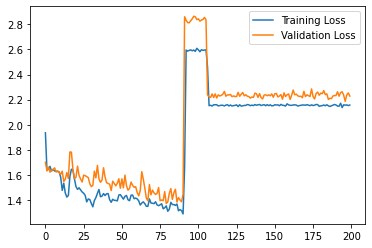

In [42]:
plt.plot(history["loss"], label="Training Loss")
plt.plot(history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()

In [43]:
model.load_state_dict(best["state"])

<All keys matched successfully>

## Model training and inference

Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


Test video path: v_TennisSwing_g05_c03.avi
  Punch: 93.07%
  TennisSwing:  2.45%
  ShavingBeard:  1.72%
  CricketShot:  1.48%
  PlayingCello:  1.28%


Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [0


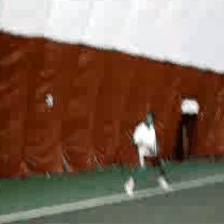

In [46]:
from tensorflow_docs.vis import embed

def prepare_single_video(frames):
#     frame_features = np.zeros(
#         shape=(num_samples, MAX_SEQ_LENGTH, 3, IMG_SIZE, IMG_SIZE), dtype="float32"
#     )

    # Pad shorter videos.
    if len(frames) < MAX_SEQ_LENGTH:
        diff = MAX_SEQ_LENGTH - len(frames)
        padding = np.zeros((diff, IMG_SIZE, IMG_SIZE, 3))
        frames = np.concatenate(frames, padding)

    frames = frames[:20]
    frames = frames[None, ...]

    return frames


def predict_action(path):
    class_vocab = classes

    frames = load_video(os.path.join("test", path))
    frame_features = prepare_single_video(frames)
    model.eval()
    probabilities = model.forward(torch.FloatTensor(frame_features).to(device))[0].detach().cpu().clone()
    probabilities = torch.nn.functional.softmax(probabilities, dim=0).numpy()
    for i in np.argsort(probabilities)[::-1]:
        print(f"  {class_vocab[i]}: {probabilities[i]*100:5.2f}%")
    return frames


# This utility is for visualization.
# Referenced from:
# https://www.tensorflow.org/hub/tutorials/action_recognition_with_tf_hub
def to_gif(images):
#     converted_images = np.array(images, dtype='uint8')
    converted_images = images#.astype(np.uint8)
    imageio.mimsave("animation.gif", converted_images, fps=10)
    return embed.embed_file("animation.gif")


test_video = np.random.choice(test_df["video_name"].values.tolist())
print(f"Test video path: {test_video}")
test_frames = predict_action(test_video)
test_frames = rearrange(test_frames, 'n c h w -> n h w c')
to_gif(test_frames[:MAX_SEQ_LENGTH])

---